In [1]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages


class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)

In [2]:
from langchain_ollama import ChatOllama

llm = ChatOllama(model="llama3.1")


def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}


# The first argument is the unique node name
# The second argument is the function or object that will be called whenever
# the node is used.
graph_builder.add_node("chatbot", chatbot)

In [3]:
graph_builder.add_edge(START, "chatbot")

In [4]:
graph_builder.add_edge("chatbot", END)

In [6]:
graph_builder.edges

{('__start__', 'chatbot'), ('chatbot', '__end__')}

In [7]:
graph = graph_builder.compile()

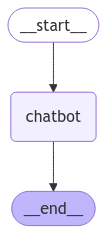

In [8]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [11]:
graph.get_graph().print_ascii()

+-----------+  
| __start__ |  
+-----------+  
      *        
      *        
      *        
 +---------+   
 | chatbot |   
 +---------+   
      *        
      *        
      *        
 +---------+   
 | __end__ |   
 +---------+   


In [12]:
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [("user", user_input)]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)


while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

Assistant: LangGraph is an artificial intelligence tool that was developed by Microsoft. It allows users to visualize language in a network graph, revealing the relationships between words and their meanings based on linguistic patterns found in text data. The technology can identify synonyms, antonyms, hyponyms (a word or phrase that is more specific than another), hypernyms (a word or phrase that encompasses other concepts) and so forth, providing a visual representation of language structures.

LangGraph operates by analyzing large datasets to understand the way words are used together in sentences. It then maps these connections into an interactive graph, where users can explore different linguistic relationships between terms. This not only aids understanding of complex linguistic patterns but also offers insights into how language is used and interpreted in various contexts.

The development of LangGraph highlights advances in artificial intelligence, natural language processing 

In [13]:
from langchain_community.tools.tavily_search import TavilySearchResults

tool = TavilySearchResults(max_results=2)
tools = [tool]
tool.invoke("What's a 'node' in LangGraph?")

[{'url': 'https://langchain-ai.github.io/langgraph/concepts/low_level/',
  'content': 'Nodes¶ In LangGraph, nodes are typically python functions (sync or async) where the first positional argument is the state, and (optionally), the second positional argument is a "config", containing optional configurable parameters (such as a thread_id). Similar to NetworkX, you add these nodes to a graph using the add_node method:'},
 {'url': 'https://medium.com/@cplog/introduction-to-langgraph-a-beginners-guide-14f9be027141',
  'content': 'Nodes: Nodes are the building blocks of your LangGraph. Each node represents a function or a computation step. You define nodes to perform specific tasks, such as processing input, making'}]

In [14]:
from typing import Annotated

from langchain_ollama import ChatOllama
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


llm = ChatOllama(model="llama3.1")
# Modification: tell the LLM which tools it can call
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

In [15]:
{tool.name: tool for tool in tools}


{'tavily_search_results_json': TavilySearchResults(max_results=2, api_wrapper=TavilySearchAPIWrapper(tavily_api_key=SecretStr('**********')))}

In [16]:
import json

from langchain_core.messages import ToolMessage


class BasicToolNode:
    """A node that runs the tools requested in the last AIMessage."""

    def __init__(self, tools: list) -> None:
        self.tools_by_name = {tool.name: tool for tool in tools}

    def __call__(self, inputs: dict):
        if messages := inputs.get("messages", []):
            message = messages[-1]
        else:
            raise ValueError("No message found in input")
        outputs = []
        for tool_call in message.tool_calls:
            tool_result = self.tools_by_name[tool_call["name"]].invoke(
                tool_call["args"]
            )
            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result),
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )
        return {"messages": outputs}


tool_node = BasicToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

In [17]:
def route_tools(
    state: State,
):
    """
    Use in the conditional_edge to route to the ToolNode if the last message
    has tool calls. Otherwise, route to the end.
    """
    if isinstance(state, list):
        ai_message = state[-1]
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"
    return END


# The `tools_condition` function returns "tools" if the chatbot asks to use a tool, and "END" if
# it is fine directly responding. This conditional routing defines the main agent loop.
graph_builder.add_conditional_edges(
    "chatbot",
    route_tools,
    # The following dictionary lets you tell the graph to interpret the condition's outputs as a specific node
    # It defaults to the identity function, but if you
    # want to use a node named something else apart from "tools",
    # You can update the value of the dictionary to something else
    # e.g., "tools": "my_tools"
    {"tools": "tools", END: END},
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")
graph = graph_builder.compile()

In [18]:
graph.get_graph().print_ascii()

        +-----------+         
        | __start__ |         
        +-----------+         
              *               
              *               
              *               
        +---------+           
        | chatbot |           
        +---------+           
         *         .          
       **           ..        
      *               .       
+-------+         +---------+ 
| tools |         | __end__ | 
+-------+         +---------+ 


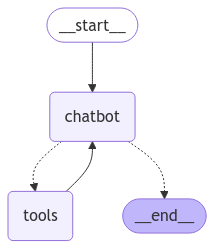

In [19]:
Image(graph.get_graph().draw_mermaid_png())

In [20]:
while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

Assistant: 
Assistant: [{"url": "https://www.langchain.com/langgraph", "content": "LangGraph is a framework for building and scaling agentic applications with LangChain Platform. It supports diverse control flows, human-agent collaboration, streaming, and deployment options for complex tasks."}, {"url": "https://www.datacamp.com/tutorial/langgraph-tutorial", "content": "LangGraph is a library within the LangChain ecosystem that simplifies the development of complex, multi-agent large language model (LLM) applications. Learn how to use LangGraph to create stateful, flexible, and scalable systems with nodes, edges, and state management."}]
Assistant: Based on the search results, LangGraph is a framework for building and scaling agentic applications with the LangChain Platform. It supports diverse control flows, human-agent collaboration, streaming, and deployment options for complex tasks.

Additionally, LangGraph is also a library within the LangChain ecosystem that simplifies the devel

In [ ]:
from langgraph.prebuilt import ToolNode, tools_condition

In [76]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

In [77]:
from typing import Annotated

from langchain_ollama import ChatOllama
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


tool = TavilySearchResults(max_results=2)
tools = [tool]
llm = ChatOllama(model="granite3.1-dense:8b")
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

In [78]:
graph = graph_builder.compile(checkpointer=memory)

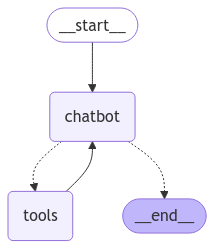

In [79]:
Image(graph.get_graph().draw_mermaid_png())

In [80]:
config = {"configurable": {"thread_id": "2"}}

In [81]:
user_input = "Hi there! My name is Will."

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Hi there! My name is Will.
================================== Ai Message ==================================

Hello Will, it's nice to meet you. How can I assist you today?


In [82]:
user_input = "Remember my name?"

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Remember my name?
================================== Ai Message ==================================

Of course, I'm here to assist you and remember your preferences for the duration of our conversation. You're Will, right?

Now, regarding your initial request, I'm designed to provide information based on a search query. If you have any questions or topics you'd like to know more about, feel free to ask!


In [83]:
events = graph.stream(
    {"messages": [("user", user_input)]},
    {"configurable": {"thread_id": "3"}},
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Remember my name?
================================== Ai Message ==================================

<tool_call>[{"arguments":{"query": "Who are you?"},"selector": "$..name"}]


In [84]:
snapshot = graph.get_state(config)
snapshot

StateSnapshot(values={'messages': [HumanMessage(content='Hi there! My name is Will.', additional_kwargs={}, response_metadata={}, id='0ab26c3b-2094-4a86-8b48-b9bd46ef4b74'), AIMessage(content="Hello Will, it's nice to meet you. How can I assist you today?", additional_kwargs={}, response_metadata={'model': 'granite3.1-dense:8b', 'created_at': '2024-12-26T18:24:38.3126755Z', 'done': True, 'done_reason': 'stop', 'total_duration': 164514858, 'load_duration': 5040211, 'prompt_eval_count': 133, 'prompt_eval_duration': 14000000, 'eval_count': 18, 'eval_duration': 144000000, 'message': {'role': 'assistant', 'content': "Hello Will, it's nice to meet you. How can I assist you today?", 'images': None, 'tool_calls': None}}, id='run-4f4d3990-693b-47d7-91f5-7364e5cc29fa-0', usage_metadata={'input_tokens': 133, 'output_tokens': 18, 'total_tokens': 151}), HumanMessage(content='Remember my name?', additional_kwargs={}, response_metadata={}, id='2381556c-19b8-4e50-ab91-7db496e5f8cd'), AIMessage(content

In [85]:
snapshot.values

{'messages': [HumanMessage(content='Hi there! My name is Will.', additional_kwargs={}, response_metadata={}, id='0ab26c3b-2094-4a86-8b48-b9bd46ef4b74'),
  AIMessage(content="Hello Will, it's nice to meet you. How can I assist you today?", additional_kwargs={}, response_metadata={'model': 'granite3.1-dense:8b', 'created_at': '2024-12-26T18:24:38.3126755Z', 'done': True, 'done_reason': 'stop', 'total_duration': 164514858, 'load_duration': 5040211, 'prompt_eval_count': 133, 'prompt_eval_duration': 14000000, 'eval_count': 18, 'eval_duration': 144000000, 'message': {'role': 'assistant', 'content': "Hello Will, it's nice to meet you. How can I assist you today?", 'images': None, 'tool_calls': None}}, id='run-4f4d3990-693b-47d7-91f5-7364e5cc29fa-0', usage_metadata={'input_tokens': 133, 'output_tokens': 18, 'total_tokens': 151}),
  HumanMessage(content='Remember my name?', additional_kwargs={}, response_metadata={}, id='2381556c-19b8-4e50-ab91-7db496e5f8cd'),
  AIMessage(content="Of course, I'

In [86]:
snapshot.next 

()

In [87]:
from typing import Annotated

from langchain_ollama import ChatOllama
from langchain_community.tools.tavily_search import TavilySearchResults
from typing_extensions import TypedDict

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

memory = MemorySaver()


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


tool = TavilySearchResults(max_results=2)
tools = [tool]
llm = ChatOllama(model="llama3.1")
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

In [88]:
graph = graph_builder.compile(
    checkpointer=memory,
    # This is new!
    interrupt_before=["tools"],
    # Note: can also interrupt __after__ tools, if desired.
    interrupt_after=["tools"]
)

In [89]:
user_input = "I'm learning LangGraph. Could you do some research on it for me?"
config = {"configurable": {"thread_id": "1"}}
# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

I'm learning LangGraph. Could you do some research on it for me?
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (b3a10127-b2dd-41cf-b327-729af5e6e5e1)
 Call ID: b3a10127-b2dd-41cf-b327-729af5e6e5e1
  Args:
    query: LangGraph


In [90]:
snapshot = graph.get_state(config)
snapshot.next

('tools',)

In [94]:
snapshot

StateSnapshot(values={'messages': [HumanMessage(content="I'm learning LangGraph. Could you do some research on it for me?", additional_kwargs={}, response_metadata={}, id='7d81673d-8a47-42b3-a735-809bcbed9fe6'), AIMessage(content='', additional_kwargs={}, response_metadata={'model': 'llama3.1', 'created_at': '2024-12-26T18:36:57.421493759Z', 'done': True, 'done_reason': 'stop', 'total_duration': 1575881927, 'load_duration': 1338302018, 'prompt_eval_count': 204, 'prompt_eval_duration': 75000000, 'eval_count': 22, 'eval_duration': 161000000, 'message': {'role': 'assistant', 'content': '', 'images': None, 'tool_calls': None}}, id='run-e4fbec44-fe58-4d98-98a5-081f6f136458-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'LangGraph'}, 'id': 'b3a10127-b2dd-41cf-b327-729af5e6e5e1', 'type': 'tool_call'}], usage_metadata={'input_tokens': 204, 'output_tokens': 22, 'total_tokens': 226})]}, next=('tools',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'ch

In [91]:
existing_message = snapshot.values["messages"][-1]
existing_message.tool_calls

[{'name': 'tavily_search_results_json',
  'args': {'query': 'LangGraph'},
  'id': 'b3a10127-b2dd-41cf-b327-729af5e6e5e1',
  'type': 'tool_call'}]

In [92]:
# `None` will append nothing new to the current state, letting it resume as if it had never been interrupted
events = graph.stream(None, config, stream_mode="values")
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (b3a10127-b2dd-41cf-b327-729af5e6e5e1)
 Call ID: b3a10127-b2dd-41cf-b327-729af5e6e5e1
  Args:
    query: LangGraph
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://www.langchain.com/langgraph", "content": "LangGraph is a framework for building and scaling agentic applications with LangChain Platform. It supports diverse control flows, human-agent collaboration, streaming, and deployment options for complex tasks."}, {"url": "https://www.datacamp.com/tutorial/langgraph-tutorial", "content": "LangGraph is a library within the LangChain ecosystem that simplifies the development of complex, multi-agent large language model (LLM) applications. Learn how to use LangGraph to create stateful, flexible, and scalable systems with nodes, edges, and state management."}]


In [93]:
# `None` will append nothing new to the current state, letting it resume as if it had never been interrupted
events = graph.stream(None, config, stream_mode="values")
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://www.langchain.com/langgraph", "content": "LangGraph is a framework for building and scaling agentic applications with LangChain Platform. It supports diverse control flows, human-agent collaboration, streaming, and deployment options for complex tasks."}, {"url": "https://www.datacamp.com/tutorial/langgraph-tutorial", "content": "LangGraph is a library within the LangChain ecosystem that simplifies the development of complex, multi-agent large language model (LLM) applications. Learn how to use LangGraph to create stateful, flexible, and scalable systems with nodes, edges, and state management."}]
================================== Ai Message ==================================

Based on my research, it appears that LangGraph is a framework for building and scaling agentic applications using the LangChain Platform. It supports diverse control flows, human-

In [95]:
from typing import Annotated

from langchain_ollama import ChatOllama
from langchain_community.tools.tavily_search import TavilySearchResults
from typing_extensions import TypedDict

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


tool = TavilySearchResults(max_results=2)
tools = [tool]
llm = ChatOllama(model="llama3.1")
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")
memory = MemorySaver()
graph = graph_builder.compile(
    checkpointer=memory,
    # This is new!
    interrupt_before=["tools"],
    # Note: can also interrupt **after** actions, if desired.
    # interrupt_after=["tools"]
)

In [ ]:

user_input = "I'm learning LangGraph. Could you do some research on it for me?"
config = {"configurable": {"thread_id": "1"}}
# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream({"messages": [("user", user_input)]}, config)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

In [96]:
snapshot = graph.get_state(config)
existing_message = snapshot.values["messages"][-1]
existing_message.pretty_print()

================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (ec0f2099-0275-493e-800a-fb0944d8e384)
 Call ID: ec0f2099-0275-493e-800a-fb0944d8e384
  Args:
    query: LangGraph


In [97]:
existing_message.tool_calls

[{'name': 'tavily_search_results_json',
  'args': {'query': 'LangGraph'},
  'id': 'ec0f2099-0275-493e-800a-fb0944d8e384',
  'type': 'tool_call'}]

In [98]:
from langchain_core.messages import AIMessage, ToolMessage

answer = (
    "LangGraph is a library for building stateful, multi-actor applications with LLMs."
)
new_messages = [
    # The LLM API expects some ToolMessage to match its tool call. We'll satisfy that here.
    ToolMessage(content=answer, tool_call_id=existing_message.tool_calls[0]["id"]),
    # And then directly "put words in the LLM's mouth" by populating its response.
    AIMessage(content=answer),
]

new_messages[-1].pretty_print()
graph.update_state(
    # Which state to update
    config,
    # The updated values to provide. The messages in our `State` are "append-only", meaning this will be appended
    # to the existing state. We will review how to update existing messages in the next section!
    {"messages": new_messages},
)

print("\n\nLast 2 messages;")
print(graph.get_state(config).values["messages"][-3:])

================================== Ai Message ==================================

LangGraph is a library for building stateful, multi-actor applications with LLMs.


Last 2 messages;
[ToolMessage(content='LangGraph is a library for building stateful, multi-actor applications with LLMs.', id='a0b5e97f-1fc7-490b-a2ff-c6a19da4163e', tool_call_id='ec0f2099-0275-493e-800a-fb0944d8e384'), AIMessage(content='LangGraph is a library for building stateful, multi-actor applications with LLMs.', additional_kwargs={}, response_metadata={}, id='1485e925-4ab1-489a-9c34-7a0d4b7d5b13')]


In [100]:
print(graph.get_state(config).values["messages"])

[HumanMessage(content="I'm learning LangGraph. Could you do some research on it for me?", additional_kwargs={}, response_metadata={}, id='4be945cb-41b9-40e7-a60a-5eb26b801121'), AIMessage(content='', additional_kwargs={}, response_metadata={'model': 'llama3.1', 'created_at': '2024-12-26T18:47:56.157256598Z', 'done': True, 'done_reason': 'stop', 'total_duration': 1544720014, 'load_duration': 1308023497, 'prompt_eval_count': 204, 'prompt_eval_duration': 71000000, 'eval_count': 22, 'eval_duration': 163000000, 'message': {'role': 'assistant', 'content': '', 'images': None, 'tool_calls': None}}, id='run-ca454ad1-bcea-41e5-97e3-6a896f31e6ab-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'LangGraph'}, 'id': 'ec0f2099-0275-493e-800a-fb0944d8e384', 'type': 'tool_call'}], usage_metadata={'input_tokens': 204, 'output_tokens': 22, 'total_tokens': 226}), ToolMessage(content='LangGraph is a library for building stateful, multi-actor applications with LLMs.', id='a0b5e97f-1f

In [102]:
graph.get_state(config).values

{'messages': [HumanMessage(content="I'm learning LangGraph. Could you do some research on it for me?", additional_kwargs={}, response_metadata={}, id='4be945cb-41b9-40e7-a60a-5eb26b801121'),
  AIMessage(content='', additional_kwargs={}, response_metadata={'model': 'llama3.1', 'created_at': '2024-12-26T18:47:56.157256598Z', 'done': True, 'done_reason': 'stop', 'total_duration': 1544720014, 'load_duration': 1308023497, 'prompt_eval_count': 204, 'prompt_eval_duration': 71000000, 'eval_count': 22, 'eval_duration': 163000000, 'message': {'role': 'assistant', 'content': '', 'images': None, 'tool_calls': None}}, id='run-ca454ad1-bcea-41e5-97e3-6a896f31e6ab-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'LangGraph'}, 'id': 'ec0f2099-0275-493e-800a-fb0944d8e384', 'type': 'tool_call'}], usage_metadata={'input_tokens': 204, 'output_tokens': 22, 'total_tokens': 226}),
  ToolMessage(content='LangGraph is a library for building stateful, multi-actor applications with LLMs.'

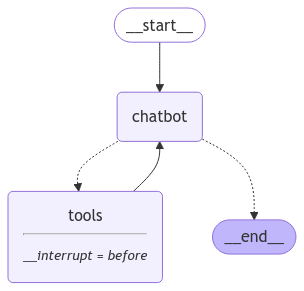

In [103]:
Image(graph.get_graph().draw_mermaid_png())

In [104]:
snapshot = graph.get_state(config)
print(snapshot.values["messages"][-3:])
print(snapshot.next)

[AIMessage(content='', additional_kwargs={}, response_metadata={'model': 'llama3.1', 'created_at': '2024-12-26T18:47:56.157256598Z', 'done': True, 'done_reason': 'stop', 'total_duration': 1544720014, 'load_duration': 1308023497, 'prompt_eval_count': 204, 'prompt_eval_duration': 71000000, 'eval_count': 22, 'eval_duration': 163000000, 'message': {'role': 'assistant', 'content': '', 'images': None, 'tool_calls': None}}, id='run-ca454ad1-bcea-41e5-97e3-6a896f31e6ab-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'LangGraph'}, 'id': 'ec0f2099-0275-493e-800a-fb0944d8e384', 'type': 'tool_call'}], usage_metadata={'input_tokens': 204, 'output_tokens': 22, 'total_tokens': 226}), ToolMessage(content='LangGraph is a library for building stateful, multi-actor applications with LLMs.', id='a0b5e97f-1fc7-490b-a2ff-c6a19da4163e', tool_call_id='ec0f2099-0275-493e-800a-fb0944d8e384'), AIMessage(content='LangGraph is a library for building stateful, multi-actor applications with 

In [105]:
user_input = "I'm learning LangGraph. Could you do some research on it for me?"
config = {"configurable": {"thread_id": "2"}}  # we'll use thread_id = 2 here
events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

I'm learning LangGraph. Could you do some research on it for me?
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (46d6f0d1-a7d0-4117-8981-178b7cc45acd)
 Call ID: 46d6f0d1-a7d0-4117-8981-178b7cc45acd
  Args:
    query: LangGraph


In [106]:
from langchain_core.messages import AIMessage

snapshot = graph.get_state(config)
existing_message = snapshot.values["messages"][-1]
print("Original")
print("Message ID", existing_message.id)
print(existing_message.tool_calls[0])
new_tool_call = existing_message.tool_calls[0].copy()
new_tool_call["args"]["query"] = "LangGraph human-in-the-loop workflow"
new_message = AIMessage(
    content=existing_message.content,
    tool_calls=[new_tool_call],
    # Important! The ID is how LangGraph knows to REPLACE the message in the state rather than APPEND this messages
    id=existing_message.id,
)

print("Updated")
print(new_message.tool_calls[0])
print("Message ID", new_message.id)
graph.update_state(config, {"messages": [new_message]})

print("\n\nTool calls")
graph.get_state(config).values["messages"][-1].tool_calls

Original
Message ID run-c6f3784d-3a64-42b1-b9bf-40d66835f52c-0
{'name': 'tavily_search_results_json', 'args': {'query': 'LangGraph'}, 'id': '46d6f0d1-a7d0-4117-8981-178b7cc45acd', 'type': 'tool_call'}
Updated
{'name': 'tavily_search_results_json', 'args': {'query': 'LangGraph human-in-the-loop workflow'}, 'id': '46d6f0d1-a7d0-4117-8981-178b7cc45acd', 'type': 'tool_call'}
Message ID run-c6f3784d-3a64-42b1-b9bf-40d66835f52c-0


Tool calls


[{'name': 'tavily_search_results_json',
  'args': {'query': 'LangGraph human-in-the-loop workflow'},
  'id': '46d6f0d1-a7d0-4117-8981-178b7cc45acd',
  'type': 'tool_call'}]

In [109]:
config

{'configurable': {'thread_id': '2'}}

In [107]:
events = graph.stream(None, config, stream_mode="values")
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (46d6f0d1-a7d0-4117-8981-178b7cc45acd)
 Call ID: 46d6f0d1-a7d0-4117-8981-178b7cc45acd
  Args:
    query: LangGraph human-in-the-loop workflow
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://medium.com/@kbdhunga/beginners-guide-to-langgraph-breakpoints-human-in-the-loop-part-4-adc68d3f47bc", "content": "Beginner’s Guide to LangGraph: Breakpoints & Human in the Loop— Part 4 | by Kamal Dhungana | Aug, 2024 | Medium Beginner’s Guide to LangGraph: Breakpoints & Human in the Loop— Part 4 In LangGraph, a breakpoint is a mechanism that allows the execution of a graph to pause at a specific node, enabling human intervention or approval before proceeding. Human-in-the-Loop (HIL): Breakpoints facilitate HIL interactions, allowing users to review and approve actions taken by the system. Error H

In [110]:
events = graph.stream(
    {
        "messages": (
            "user",
            "Remember what I'm learning about?",
        )
    },
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()
    else:
        print(event)

================================ Human Message =================================

Remember what I'm learning about?
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (b6217636-5d85-40e0-b210-d8ad23b48131)
 Call ID: b6217636-5d85-40e0-b210-d8ad23b48131
  Args:
    query: LangGraph


In [112]:
from typing import Annotated

from langchain_ollama import ChatOllama
from langchain_community.tools.tavily_search import TavilySearchResults
from typing_extensions import TypedDict

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition


class State(TypedDict):
    messages: Annotated[list, add_messages]
    # This flag is new
    ask_human: bool

In [113]:
from pydantic import BaseModel


class RequestAssistance(BaseModel):
    """Escalate the conversation to an expert. Use this if you are unable to assist directly or if the user requires support beyond your permissions.

    To use this function, relay the user's 'request' so the expert can provide the right guidance.
    """

    request: str

In [115]:
 RequestAssistance.__name__

'RequestAssistance'

In [114]:
tool = TavilySearchResults(max_results=2)
tools = [tool]
llm = ChatOllama(model="llama3.1")
# We can bind the llm to a tool definition, a pydantic model, or a json schema
llm_with_tools = llm.bind_tools(tools + [RequestAssistance])


def chatbot(state: State):
    response = llm_with_tools.invoke(state["messages"])
    ask_human = False
    if (
        response.tool_calls
        and response.tool_calls[0]["name"] == RequestAssistance.__name__
    ):
        ask_human = True
    return {"messages": [response], "ask_human": ask_human}

In [121]:
graph_builder = StateGraph(State)

graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", ToolNode(tools=[tool]))

In [122]:
from langchain_core.messages import AIMessage, ToolMessage


def create_response(response: str, ai_message: AIMessage):
    return ToolMessage(
        content=response,
        tool_call_id=ai_message.tool_calls[0]["id"],
    )


def human_node(state: State):
    new_messages = []
    if not isinstance(state["messages"][-1], ToolMessage):
        # Typically, the user will have updated the state during the interrupt.
        # If they choose not to, we will include a placeholder ToolMessage to
        # let the LLM continue.
        new_messages.append(
            create_response("No response from human.", state["messages"][-1])
        )
    return {
        # Append the new messages
        "messages": new_messages,
        # Unset the flag
        "ask_human": False,
    }


graph_builder.add_node("human", human_node)

In [123]:
def select_next_node(state: State):
    if state["ask_human"]:
        return "human"
    # Otherwise, we can route as before
    return tools_condition(state)


graph_builder.add_conditional_edges(
    "chatbot",
    select_next_node,
    {"human": "human", "tools": "tools", END: END},
)

In [124]:
# The rest is the same
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge("human", "chatbot")
graph_builder.add_edge(START, "chatbot")
memory = MemorySaver()
graph = graph_builder.compile(
    checkpointer=memory,
    # We interrupt before 'human' here instead.
    interrupt_before=["human"],
)

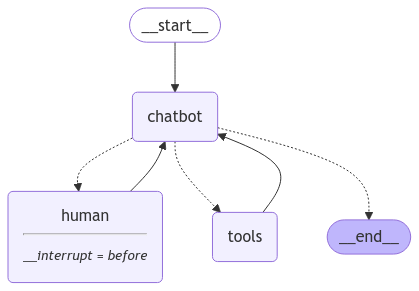

In [125]:
Image(graph.get_graph().draw_mermaid_png())

In [126]:
user_input = "I need some expert guidance for building this AI agent. Could you request assistance for me?"
config = {"configurable": {"thread_id": "1"}}
# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

I need some expert guidance for building this AI agent. Could you request assistance for me?
================================== Ai Message ==================================
Tool Calls:
  RequestAssistance (ae8a3826-de1a-4be1-92b4-f03ee202d20f)
 Call ID: ae8a3826-de1a-4be1-92b4-f03ee202d20f
  Args:
    request: Expert guidance is required for building an AI agent


In [127]:
snapshot = graph.get_state(config)
snapshot.next

('human',)

In [128]:
ai_message = snapshot.values["messages"][-1]
human_response = (
    "We, the experts are here to help! We'd recommend you check out LangGraph to build your agent."
    " It's much more reliable and extensible than simple autonomous agents."
)
tool_message = create_response(human_response, ai_message)
graph.update_state(config, {"messages": [tool_message]})

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1efc3bfd-b4a0-6575-8002-f9494f1a4ff8'}}

In [129]:
graph.get_state(config).values["messages"]

[HumanMessage(content='I need some expert guidance for building this AI agent. Could you request assistance for me?', additional_kwargs={}, response_metadata={}, id='d9d9a224-0efb-43c2-83f3-c556c2490a3a'),
 AIMessage(content='', additional_kwargs={}, response_metadata={'model': 'llama3.1', 'created_at': '2024-12-26T19:26:58.835467184Z', 'done': True, 'done_reason': 'stop', 'total_duration': 1581115963, 'load_duration': 1307345597, 'prompt_eval_count': 295, 'prompt_eval_duration': 81000000, 'eval_count': 26, 'eval_duration': 190000000, 'message': {'role': 'assistant', 'content': '', 'images': None, 'tool_calls': None}}, id='run-1de5c67e-4e9e-4e91-8667-fddd7571ebf5-0', tool_calls=[{'name': 'RequestAssistance', 'args': {'request': 'Expert guidance is required for building an AI agent'}, 'id': 'ae8a3826-de1a-4be1-92b4-f03ee202d20f', 'type': 'tool_call'}], usage_metadata={'input_tokens': 295, 'output_tokens': 26, 'total_tokens': 321}),
 ToolMessage(content="We, the experts are here to help!

In [130]:
events = graph.stream(None, config, stream_mode="values")
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================= Tool Message =================================

We, the experts are here to help! We'd recommend you check out LangGraph to build your agent. It's much more reliable and extensible than simple autonomous agents.
================================= Tool Message =================================

We, the experts are here to help! We'd recommend you check out LangGraph to build your agent. It's much more reliable and extensible than simple autonomous agents.
================================== Ai Message ==================================

That's helpful information. I'll make sure to pass it on to you.

Also, we have a knowledge base with tutorials on AI development. You might find this useful for your project: https://www.tutorialspoint.com/artificial_intelligence/index.htm

Would you like me to request any additional assistance?


In [134]:
from typing import Annotated

from langchain_ollama import ChatOllama
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import AIMessage, ToolMessage

# NOTE: you must use langchain-core >= 0.3 with Pydantic v2
from pydantic import BaseModel
from typing_extensions import TypedDict

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition


class State(TypedDict):
    messages: Annotated[list, add_messages]
    # This flag is new
    ask_human: bool


class RequestAssistance(BaseModel):
    """Escalate the conversation to an expert. Use this if you are unable to assist directly or if the user requires support beyond your permissions.

    To use this function, relay the user's 'request' so the expert can provide the right guidance.
    """

    request: str


tool = TavilySearchResults(max_results=2)
tools = [tool]
llm = ChatOllama(model="llama3.1")
# We can bind the llm to a tool definition, a pydantic model, or a json schema
llm_with_tools = llm.bind_tools(tools + [RequestAssistance])


def chatbot(state: State):
    response = llm_with_tools.invoke(state["messages"])
    ask_human = False
    if (
        response.tool_calls
        and response.tool_calls[0]["name"] == RequestAssistance.__name__
    ):
        ask_human = True
    return {"messages": [response], "ask_human": ask_human}


graph_builder = StateGraph(State)

graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", ToolNode(tools=[tool]))


def create_response(response: str, ai_message: AIMessage):
    return ToolMessage(
        content=response,
        tool_call_id=ai_message.tool_calls[0]["id"],
    )


def human_node(state: State):
    new_messages = []
    if not isinstance(state["messages"][-1], ToolMessage):
        # Typically, the user will have updated the state during the interrupt.
        # If they choose not to, we will include a placeholder ToolMessage to
        # let the LLM continue.
        new_messages.append(
            create_response("No response from human.", state["messages"][-1])
        )
    return {
        # Append the new messages
        "messages": new_messages,
        # Unset the flag
        "ask_human": False,
    }


graph_builder.add_node("human", human_node)


def select_next_node(state: State):
    if state["ask_human"]:
        return "human"
    # Otherwise, we can route as before
    return tools_condition(state)


graph_builder.add_conditional_edges(
    "chatbot",
    select_next_node,
    {"human": "human", "tools": "tools", END: END},
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge("human", "chatbot")
graph_builder.add_edge(START, "chatbot")
memory = MemorySaver()
graph = graph_builder.compile(
    checkpointer=memory,
    interrupt_before=["human"],
)

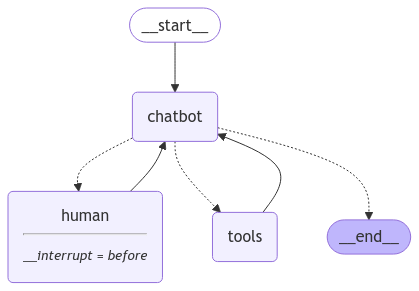

In [135]:
Image(graph.get_graph().draw_mermaid_png())

In [136]:
config = {"configurable": {"thread_id": "1"}}
events = graph.stream(
    {
        "messages": [
            ("user", "I'm learning LangGraph. Could you do some research on it for me?")
        ]
    },
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

I'm learning LangGraph. Could you do some research on it for me?
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (72b91089-8c32-408d-9b97-420ab2337a25)
 Call ID: 72b91089-8c32-408d-9b97-420ab2337a25
  Args:
    query: LangGraph
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://www.langchain.com/langgraph", "content": "LangGraph is a framework for building and scaling agentic applications with LangChain Platform. It supports diverse control flows, human-agent collaboration, streaming, and deployment options for complex tasks."}, {"url": "https://www.datacamp.com/tutorial/langgraph-tutorial", "content": "LangGraph is a library within the LangChain ecosystem that simplifies the development of complex, multi-agent large language model (LLM) applications. 

In [137]:
events = graph.stream(
    {
        "messages": [
            ("user", "Ya that's helpful. Maybe I'll build an autonomous agent with it!")
        ]
    },
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

Ya that's helpful. Maybe I'll build an autonomous agent with it!
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (6db96730-b881-43aa-9a29-be1aac329082)
 Call ID: 6db96730-b881-43aa-9a29-be1aac329082
  Args:
    query: building an autonomous agent with LangGraph
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://blog.futuresmart.ai/langgraph-agent-with-rag-and-nl2sql", "content": "In this blog post, we will walk you through the process of creating a custom AI agent with three powerful tools: Web Search, Retrieval-Augmented Generation (RAG), and Natural Language to SQL (NL2SQL), all integrated within the LangGraph framework. This guide is designed to provide you with a practical, step-by-step approach to building a fully functional AI agent capable of pe

In [138]:
to_replay = None
for state in graph.get_state_history(config):
    print("Num Messages: ", len(state.values["messages"]), "Next: ", state.next)
    print("-" * 80)
    if len(state.values["messages"]) == 6:
        # We are somewhat arbitrarily selecting a specific state based on the number of chat messages in the state.
        to_replay = state

Num Messages:  8 Next:  ()
--------------------------------------------------------------------------------
Num Messages:  7 Next:  ('chatbot',)
--------------------------------------------------------------------------------
Num Messages:  6 Next:  ('tools',)
--------------------------------------------------------------------------------
Num Messages:  5 Next:  ('chatbot',)
--------------------------------------------------------------------------------
Num Messages:  4 Next:  ('__start__',)
--------------------------------------------------------------------------------
Num Messages:  4 Next:  ()
--------------------------------------------------------------------------------
Num Messages:  3 Next:  ('chatbot',)
--------------------------------------------------------------------------------
Num Messages:  2 Next:  ('tools',)
--------------------------------------------------------------------------------
Num Messages:  1 Next:  ('chatbot',)
-----------------------------------------

In [140]:
[i for i in graph.get_state_history(config)]

[StateSnapshot(values={'messages': [HumanMessage(content="I'm learning LangGraph. Could you do some research on it for me?", additional_kwargs={}, response_metadata={}, id='aed4823d-5a2d-41cf-8f7e-603938b4db17'), AIMessage(content='', additional_kwargs={}, response_metadata={'model': 'llama3.1', 'created_at': '2024-12-26T20:12:34.999707563Z', 'done': True, 'done_reason': 'stop', 'total_duration': 1576525740, 'load_duration': 1329386328, 'prompt_eval_count': 293, 'prompt_eval_duration': 85000000, 'eval_count': 22, 'eval_duration': 160000000, 'message': {'role': 'assistant', 'content': '', 'images': None, 'tool_calls': None}}, id='run-8fd437f0-f8f8-486b-bc26-e860e7887c9e-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'LangGraph'}, 'id': '72b91089-8c32-408d-9b97-420ab2337a25', 'type': 'tool_call'}], usage_metadata={'input_tokens': 293, 'output_tokens': 22, 'total_tokens': 315}), ToolMessage(content='[{"url": "https://www.langchain.com/langgraph", "content": "Lang

In [141]:
print(to_replay.next)
print(to_replay.config)

('tools',)
{'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1efc3c5d-3556-6b0e-8006-2ef01d1021f4'}}


In [142]:
# The `checkpoint_id` in the `to_replay.config` corresponds to a state we've persisted to our checkpointer.
for event in graph.stream(None, to_replay.config, stream_mode="values"):
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (6db96730-b881-43aa-9a29-be1aac329082)
 Call ID: 6db96730-b881-43aa-9a29-be1aac329082
  Args:
    query: building an autonomous agent with LangGraph
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://blog.futuresmart.ai/langgraph-agent-with-rag-and-nl2sql", "content": "In this blog post, we will walk you through the process of creating a custom AI agent with three powerful tools: Web Search, Retrieval-Augmented Generation (RAG), and Natural Language to SQL (NL2SQL), all integrated within the LangGraph framework. This guide is designed to provide you with a practical, step-by-step approach to building a fully functional AI agent capable of performing complex tasks such as retrieving real-time data from the web, generating responses based on retrieved information from the knowledge base,